In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles
import bilby
import sys
import pesummary
from pesummary.utils.samples_dict import SamplesDict
import sys
import random

## Parameters

In [220]:
"""
param_dict = {
    'mass_1': 30,
    'mass_2': 20,
    'luminosity_distance': 500,
    'theta_jn': np.pi/4,
    'ra': np.pi/3,
    'dec': np.pi/4,
    'psi': np.pi/3,
    'geocent_time': 0,
    'phase': 0,
    'a_1': 0.8,
    'a_2': 0.6,
    'tilt_1': np.pi/4,
    'tilt_2': np.pi/6,
    'phi_12': np.pi/4,
    'phi_jl': np.pi/2
}
"""
param_dict_ranges = {
    'total_mass': (10, 100),
    'mass_ratio': (0.1, 1),
    'luminosity_distance': (100, 1000),
    'theta_jn': (0, np.pi),
    'ra': (0, 2*np.pi),
    'dec': (0, np.pi),
    'psi': (0, 2*np.pi),
    'geocent_time': 0,
    'phase': 0,
    'a_1': (0, 0.99),
    'a_2': (0, 0.99),
    #'tilt_1': 0,
    #'tilt_2': 0,
    #'phi_12': 0,
    #'phi_jl': 0
    'tilt_1': (0, np.pi),
    'tilt_2': (0, np.pi),
    'phi_12': (0, 2*np.pi),
    'phi_jl': (0, 2*np.pi)
}
approx = 'IMRPhenomXPHM'
delta_f = 1./16,
f_low = 10
f_ref = f_low
f_high = 2048

In [221]:
n_samples = 50
param_dict = {}
for key, val in param_dict_ranges.items():
    if type(val) == tuple:
        start, end = val
        param_dict[key] = np.array([random.uniform(start, end) for i in range(n_samples)])
    else:
        param_dict[key] = np.ones(n_samples)*val

In [222]:
#samples = SamplesDict({key:[val] for key, val in param_dict.items()})
samples = SamplesDict(param_dict)
samples.generate_all_posterior_samples(delta_f = delta_f, f_start = f_low, f_low=f_low, f_ref=f_low, f_final=f_high)
samples

2025-09-05  11:17:11 PESummary WARNING : The redshift is being approximated using interpolation. Bear in mind that this does introduce a small error.
2025-09-05  11:17:11 PESummary INFO    : Averaging the final spin from the following fits: function bbh_final_spin_precessing_projected_UIB2016 at 0x7ed987bbea70, function bbh_final_spin_precessing_projected_Healyetal at 0x7ed987bbe8c0, function bbh_final_spin_precessing_HBR2016 at 0x7ed987bbec20
2025-09-05  11:17:11 PESummary INFO    : Averaging the peak luminosity from the following fits: function bbh_peak_luminosity_non_precessing_UIB2016 at 0x7ed987bbecb0, function bbh_peak_luminosity_non_precessing_Healyetal at 0x7ed987bbed40
2025-09-05  11:17:11 PESummary INFO    : Averaging the final mass from the following fits: function bbh_final_mass_non_precessing_UIB2016 at 0x7ed987bbe200, function bbh_final_mass_non_precessing_Healyetal at 0x7ed987bbcc10


{'total_mass': Array([93.36153421, 36.60244093, 21.57217541, 86.58845973, 16.57037392,
        27.14574456, 15.97816661, 18.19597979, 23.54245591, 49.27814082,
        98.62969316, 91.70759238, 63.10345635, 59.96200797, 60.76176245,
        86.19136963, 77.50066635, 87.71501895, 39.94689671, 51.32553127,
        59.0553635 , 76.37606109, 87.16021609, 41.39087596, 77.23316198,
        72.09134588, 68.10732414, 43.19615911, 33.88297148, 10.34122846,
        90.60824861, 61.16940385, 38.62349128, 44.91521085, 42.88619519,
        77.9261984 , 71.10119839, 21.06336377, 14.49993437, 66.78266821,
        82.23058958, 95.4543719 , 79.76405228, 41.53656557, 85.19075839,
        73.25329084, 57.26658735, 57.52294352, 39.90679792, 61.41583981]),
 'mass_ratio': Array([0.34993971, 0.91477262, 0.74473653, 0.42794277, 0.10029052,
        0.37018565, 0.24937138, 0.30271334, 0.59930995, 0.92224425,
        0.15442306, 0.99672939, 0.60867721, 0.28725445, 0.97494416,
        0.69847076, 0.7993474 , 0.32

## PyCBC

In [223]:
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector
from pycbc.filter.matchedfilter import sigmasq
import pycbc

In [224]:
PyCBC_wf_gen_keys_map = {
    'mass_1':'mass1', 
    'mass_2':'mass2', 
    'luminosity_distance':'distance',
    'iota':'inclination',
    'geocent_time':'trigger_time',
    'phase':'coa_phase',
    'ra':'ra',
    'dec':'dec',
    'psi':'polarization',
    'spin_1x':'spin1x',
    'spin_1y':'spin1y',
    'spin_1z':'spin1z',
    'spin_2x':'spin2x',
    'spin_2y':'spin2y',
    'spin_2z':'spin2z'
}

In [225]:
PyCBC_samples = {PyCBC_wf_gen_keys_map[key]:samples[key] for key in PyCBC_wf_gen_keys_map.keys()}
PyCBC_samples

{'mass1': Array([69.15978081, 19.11581591, 12.364145  , 60.63860669, 15.05999884,
        19.81172744, 12.78896485, 13.96775426, 14.72038356, 25.63573322,
        85.43635078, 45.92890402, 39.2269226 , 46.58131741, 30.76631923,
        50.7464549 , 43.0715416 , 65.96279484, 20.11233492, 46.27692551,
        39.55792194, 60.24373197, 48.14662169, 24.98787699, 55.11427931,
        48.71252152, 49.57909183, 21.84836184, 17.51008625,  6.93043232,
        62.32060352, 44.36783773, 21.41747231, 39.15366135, 33.59816075,
        46.32418206, 49.72467714, 13.08823264, 10.21448254, 41.38916163,
        49.06232642, 79.299878  , 60.88654447, 31.08441762, 53.84793759,
        44.60742758, 31.4420971 , 30.78495305, 21.36712918, 43.78424961]),
 'mass2': Array([24.2017534 , 17.48662502,  9.2080304 , 25.94985305,  1.51037508,
         7.33401713,  3.18920176,  4.22822553,  8.82207235, 23.6424076 ,
        13.19334238, 45.77868836, 23.87653374, 13.38069056, 29.99544322,
        35.44491473, 34.4291247

In [226]:
def calc_PyCBC_snr(params_dict, f_low, f_high):
    hp, hc = get_fd_waveform(**params_dict)
    dets = ['L1', 'H1', 'I1']
    hf = {}
    snrs = {}
    snr_sq_netw = 0
    for det in dets:
        fp, fc = Detector(det).antenna_pattern(params_dict['ra'], params_dict['dec'], params_dict['polarization'], params_dict['trigger_time'])
        hf[det] = hp*fp + hc*fc
        psd = pycbc.psd.read.from_txt('../noise_curves/Asharp-asd.txt', len(hf[det]), hf[det].delta_f, f_low)
        snr_sq = sigmasq(hf[det], psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)
        snrs[f'SNR_{det}'] = np.sqrt(snr_sq)
        snr_sq_netw += snr_sq
    snrs['SNR_network'] = np.sqrt(snr_sq_netw)
    return(hf, snrs)

In [227]:
#PyCBC_samples_wf_gen = {key: PyCBC_samples[key][0] for key in PyCBC_wf_gen_keys_map.values()}
PyCBC_samples_wf_gen = {key: PyCBC_samples[key] for key in PyCBC_wf_gen_keys_map.values()}
PyCBC_samples_wf_gen.update(approximant=approx, f_lower=f_low, delta_f=delta_f[0], f_ref=f_ref, f_final=f_high)
PyCBC_samples_wf_gen = pd.DataFrame(PyCBC_samples_wf_gen)
PyCBC_samples_wf_gen

,mass1,mass2,distance,inclination,trigger_time,coa_phase,ra,dec,polarization,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,approximant,f_lower,delta_f,f_ref,f_final
0,69.159781,24.201753,370.899965,2.028062,0.0,0.0,3.392275,1.441865,4.839909,-0.048544,0.231319,-0.273089,-0.032859,0.500963,0.098337,IMRPhenomXPHM,10,0.0625,10,2048
1,19.115816,17.486625,589.602655,0.517241,0.0,0.0,1.726693,2.031149,5.642991,-0.064621,-0.152886,0.145567,-0.179593,0.642014,0.337424,IMRPhenomXPHM,10,0.0625,10,2048
2,12.364145,9.208030,689.398814,2.527532,0.0,0.0,0.762571,1.592850,5.487434,-0.004655,-0.602847,0.027384,-0.519424,0.003566,0.224027,IMRPhenomXPHM,10,0.0625,10,2048
3,60.638607,25.949853,191.900022,2.684093,0.0,0.0,2.244132,1.874676,4.629488,-0.335879,-0.049562,-0.190422,-0.231518,-0.131753,0.094030,IMRPhenomXPHM,10,0.0625,10,2048
4,15.059999,1.510375,313.449289,1.986410,0.0,0.0,1.759154,1.229069,1.850746,0.788784,-0.382775,-0.232246,0.127807,0.012115,0.070728,IMRPhenomXPHM,10,0.0625,10,2048
5,19.811727,7.334017,427.136117,0.099477,0.0,0.0,2.017301,3.013619,2.322373,0.042823,0.030742,-0.267577,-0.251300,-0.077048,-0.555510,IMRPhenomXPHM,10,0.0625,10,2048
6,12.788965,3.189202,470.997567,1.954040,0.0,0.0,1.608823,0.618892,1.182345,0.108906,0.199693,-0.320378,0.089084,-0.017071,0.879083,IMRPhenomXPHM,10,0.0625,10,2048
7,13.967754,4.228226,930.734853,1.973813,0.0,0.0,3.334972,2.729729,0.375088,0.013269,-0.009828,-0.424050,0.398094,0.321279,-0.067403,IMRPhenomXPHM,10,0.0625,10,2048
8,14.720384,8.822072,692.618962,1.045267,0.0,0.0,1.774214,0.285715,3.229645,-0.420786,-0.142352,-0.310084,0.195697,-0.095969,0.272624,IMRPhenomXPHM,10,0.0625,10,2048
9,25.635733,23.642408,719.931079,3.026089,0.0,0.0,5.946968,0.988310,0.000209,-0.060885,-0.164541,0.714267,0.647204,-0.089450,0.312341,IMRPhenomXPHM,10,0.0625,10,2048


In [228]:
pycbc_hfs, pycbc_snrs = [], []
for sample in tqdm(PyCBC_samples_wf_gen.to_dict(orient='records')):
    hfs, snrs = calc_PyCBC_snr(sample, f_low=f_low, f_high=f_high)
    pycbc_hfs.append(hfs)
    pycbc_snrs.append(snrs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.65it/s]


In [229]:
pycbc_snrs = pd.DataFrame(pycbc_snrs)
pycbc_snrs

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,108.430510,140.127416,102.971641,204.929322
1,81.608651,114.841493,42.267157,147.088589
2,43.818633,54.343870,31.911857,76.757381
3,414.186847,529.028399,99.798618,679.250731
4,25.999407,31.654428,29.580528,50.527019
5,60.236447,84.994479,70.767262,125.938463
6,16.924359,18.685508,12.134592,27.979107
7,16.954730,14.727743,18.645590,29.189506
8,22.103796,19.849986,10.527699,31.518759
9,146.147076,172.436003,39.477810,229.459453


## GWBench

In [230]:
from gwbench import Network, injections_CBC_params_redshift

In [231]:
fm_params_str = 'Mc eta DL iota tc phic ra dec psi'
def run_analysis(inj_params, logging_level='WARNING', num_cores=2):
    f"""
    Parameters:
    -------------------------------------------------------------
    inj_params: dict
        dict with keys: Mc, eta, tc, phic, 
                        DL, iota, ra, dec, psi, 
                        chi1x, chi1y, chi1z, chi2x, chi2y, chi2z
    Returns:
    -----------------------
    FM: matrix
        Fisher matrix with parameter order as: {fm_params_str}
    cov: matrix
        Covariance matrix corresponding to the FM
    errors: dict
        Parameter errors
    """
    wf_model_name = 'lal_bbh'
    wf_other_var_dic = {'approximant':approx, 'fRef':f_ref}
    user_psds = {'A-Sharp':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/Asharp-asd.txt', 
                            'is_asd': True},
                 'CE40':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE40-asd.txt', 
                         'is_asd': True}, 
                 'CE20':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE20-asd.txt', 
                         'is_asd': True}, 
                 'ET10-CoBA':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/18213_ET10kmcolumns.txt', 
                              'is_asd': False}}
    user_locs = {'C1':{'longitude': -2.06175744538, 'latitude': 0.59637900541, 'arm_azimuth':0, 'which_arm':'y', 'shape':'L'}, 
                 'I1':{'longitude': 1.34444215058, 'latitude':0.34231676739, 'arm_azimuth':2.0527812170378947, #3.623591506466807, 
                       'which_arm':'x', 'shape':'L'}}
    conv_log = ('Mc', 'DL')
    ana_deriv_symbs_string = 'DL tc phic ra dec psi'
    network_spec = ['A-Sharp_L', 'A-Sharp_H', 'A-Sharp_I1']
    #network_spec = ['CE40_C1', 'CE20_CEB', 'ET10-CoBA_ET1', 'ET10-CoBA_ET2', 'ET10-CoBA_ET3']
    df = delta_f[0]
    f_arr = np.arange(f_low, f_high+df, df)
    net = Network(network_spec, logger_level=logging_level)
    net.set_net_vars(wf_model_name=wf_model_name, 
                     wf_other_var_dic=wf_other_var_dic,
                     f=f_arr, 
                     inj_params=inj_params,
                     deriv_symbs_string=fm_params_str,
                     ana_deriv_symbs_string=ana_deriv_symbs_string,
                     conv_log=conv_log, 
                     user_psds=user_psds,
                     user_locs=user_locs)
    net.calc_snrs()
    return(net)

In [232]:
gwbench_params_key = {
    'chirp_mass':'Mc',
    'symmetric_mass_ratio':'eta',
    'geocent_time':'tc',
    'phase':'phic',
    'luminosity_distance':'DL',
    'iota':'iota',
    'ra':'ra',
    'dec':'dec',
    'psi':'psi',
    'spin_1x':'chi1x',
    'spin_1y':'chi1y',
    'spin_1z':'chi1z',
    'spin_2x':'chi2x',
    'spin_2y':'chi2y',
    'spin_2z':'chi2z'
}

In [233]:
gwb_inj_params = {gwbench_params_key[key]:samples[key] for key in gwbench_params_key}
gwb_inj_params = pd.DataFrame(gwb_inj_params)
gwb_inj_params

,Mc,eta,tc,phic,DL,iota,ra,dec,psi,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z
0,34.688592,0.192028,0.0,0.0,370.899965,2.028062,3.392275,1.441865,4.839909,-0.048544,0.231319,-0.273089,-0.032859,0.500963,0.098337
1,15.913192,0.249505,0.0,0.0,589.602655,0.517241,1.726693,2.031149,5.642991,-0.064621,-0.152886,0.145567,-0.179593,0.642014,0.337424
2,9.268719,0.244649,0.0,0.0,689.398814,2.527532,0.762571,1.592850,5.487434,-0.004655,-0.602847,0.027384,-0.519424,0.003566,0.224027
3,33.934267,0.209877,0.0,0.0,191.900022,2.684093,2.244132,1.874676,4.629488,-0.335879,-0.049562,-0.190422,-0.231518,-0.131753,0.094030
4,3.717743,0.082841,0.0,0.0,313.449289,1.986410,1.759154,1.229069,1.850746,0.788784,-0.382775,-0.232246,0.127807,0.012115,0.070728
5,10.247507,0.197179,0.0,0.0,427.136117,0.099477,2.017301,3.013619,2.322373,0.042823,0.030742,-0.267577,-0.251300,-0.077048,-0.555510
6,5.316246,0.159758,0.0,0.0,470.997567,1.954040,1.608823,0.618892,1.182345,0.108906,0.199693,-0.320378,0.089084,-0.017071,0.879083
7,6.468085,0.178375,0.0,0.0,930.734853,1.973813,3.334972,2.729729,0.375088,0.013269,-0.009828,-0.424050,0.398094,0.321279,-0.067403
8,9.856517,0.234308,0.0,0.0,692.618962,1.045267,1.774214,0.285715,3.229645,-0.420786,-0.142352,-0.310084,0.195697,-0.095969,0.272624
9,21.428492,0.249591,0.0,0.0,719.931079,3.026089,5.946968,0.988310,0.000209,-0.060885,-0.164541,0.714267,0.647204,-0.089450,0.312341


In [234]:
gwb_snrs = []
for sample in tqdm(gwb_inj_params.to_dict(orient='records')):
    net = run_analysis(sample)
    snrs = {det.det_key:det.snr for det in net.detectors}
    snrs.update({'SNR_network':net.snr})
    gwb_snrs.append(snrs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.63it/s]


In [235]:
gwb_snrs = pd.DataFrame(gwb_snrs).rename(columns={'A-Sharp_L':'SNR_L1', 
                                       'A-Sharp_H':'SNR_H1', 
                                       'A-Sharp_I1':'SNR_I1'})
gwb_snrs

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,89.255009,123.149793,85.001816,174.234431
1,81.578789,114.685650,42.574125,147.038951
2,43.674976,54.083077,31.784866,76.437952
3,419.415746,535.515973,101.259569,687.706642
4,26.207232,31.282401,28.903860,50.008407
5,59.800989,84.646253,70.397279,125.287363
6,17.546997,19.935261,11.356887,28.884089
7,17.285282,14.927983,18.399605,29.328674
8,23.949243,19.431590,11.035465,32.755678
9,145.937086,172.384208,39.084503,229.219428


Text(0.5, 0, 'event count')

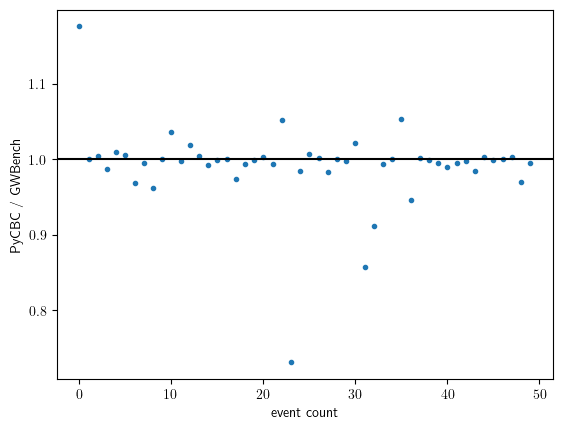

In [236]:
#plt.plot(pycbc_snrs['SNR_network'], pycbc_snrs['SNR_network']/gwb_snrs['SNR_network'], '.')
plt.plot(pycbc_snrs['SNR_network']/gwb_snrs['SNR_network'], '.')
plt.axhline(1, c='k')
plt.ylabel('PyCBC / GWBench')
#plt.xlabel('Network SNR')
plt.xlabel('event count')

In [ ]:
for dets in ['L1', 'H1', 'I1']:
    plt.plot(pycbc_snrs['SNR_network'], pycbc_snrs['SNR_network']/gwb_snrs['SNR_network'], '.')
    plt.axhline(1, c='k')
    plt.ylabel('PyCBC / GWBench')
    plt.xlabel('Network SNR')

In [182]:
import gwbench

In [ ]:
gwbench.

In [64]:
for det in net.detectors:
    print(det.det_key, det.snr)
net.snr

A-Sharp_L 136.39740507830587
A-Sharp_H 119.29177732477157
A-Sharp_I1 85.49508095923176


200.36014852665673

In [65]:
pycbc_snrs

{'SNR_L1': 135.51277456972593,
 'SNR_H1': 119.74452568830259,
 'SNR_I1': 85.8662810391637,
 'SNR_network': 200.18861536910276}